# Find duplicate candidates


Author: Thiago Nascimento (thiago.nascimento@eawag.ch)

This notebook is part of the EStreams publication and is used to find potential duplicated catchments within the dataset.

* Note that this code enables not only the replicability of the current database but also the extrapolation to new catchment areas. 
* Additionally, the user should download and insert the original raw-data in the folder of the same name prior to run this code. 
* The original third-party data used were not made available in this repository due to redistribution and storage-space reasons.  

## Requirements
**Python:**

* Python>=3.6
* Jupyter
* geopandas=0.10.2
* numpy
* os
* pandas
* shapely
* textdistance
* tqdm
* warnings

Check the Github repository for an environment.yml (for conda environments) or requirements.txt (pip) file.

**Files:**

* data/streamflow/estreams_gauging_stations.xlsx

**Directory:**

* Clone the GitHub directory locally
* Place any third-data variables in their respective directory.
* ONLY update the "PATH" variable in the section "Configurations", with their relative path to the EStreams directory. 

## References


## Observations
* As this step is rather qualitative, we believe that the users can also adapt the conditons accordinly. 


# Import modules

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import tqdm as tqdm
import os
import warnings
import textdistance
from shapely.geometry import Point

# Configurations

In [2]:
# Only editable variable:
PATH = r"/Users/thiagomedeirosdonascimento/Library/CloudStorage/OneDrive-Personal/PhD/Eawag/Papers/Paper1_Database/Paper"

# Set the directory:
os.chdir(PATH)

# Suppress all warnings
warnings.filterwarnings("ignore")

# Constrains
JARO_THRESHOLD = 0.75
SPATIAL_THRESHOLD = 1000
PROVIDER_THRESHOLD = 0.9

* #### The users should NOT change anything in the code below here.


In [3]:
# Non-editable variables:
PATH_OUTPUT = "results/"

# Import data
## Streamflow gauges network

In [4]:
network_estreams = pd.read_excel("results/estreams_gauging_stations.xlsx")
network_estreams.set_index("basin_id", inplace = True)

network_estreams

gauge_id           gauge_name gauge_country gauge_provider  \
basin_id                                                              
AT000001   200014                Bangs            AT        AT_EHYD   
AT000002   200048  Schruns (Vonbunweg)            AT        AT_EHYD   
AT000003   231662        Loruens-Aeule            AT        AT_EHYD   
AT000004   200592    Kloesterle (OEBB)            AT        AT_EHYD   
AT000005   200097  Buers (Bruecke L82)            AT        AT_EHYD   
...           ...                  ...           ...            ...   
UAGR0017  6682300          BASHTANOVKA            UA        UA_GRDC   
UAGR0018  6682500                YALTA            UA        UA_GRDC   
UAGR0019  6683010           PIONERSKOE            UA        UA_GRDC   
UAGR0020  6683200               TOKMAK            UA        UA_GRDC   
UAGR0021  6683300          NOVOSELOVKA            UA        UA_GRDC   

              river   lon_snap   lat_snap        lon        lat    area  ...  \
basin_id                                                                 ...   
AT000001      Rhein   9.534835  47.273748   9.534835  47.273748  4647.9  ...   
AT000002       Litz   9.913677  47.080301   9.913677  47.080301   102.0  ...   
AT000003        Ill   9.847765  47.132821   9.847765  47.132821   535.2  ...   
AT000004     Alfenz  10.061843  47.128994  10.061843  47.128994    66.6  ...   
AT000005     Alvier   9.802668  47.150770   9.802668  47.150770    72.2  ...   
...             ...        ...        ...        ...        ...     ...  ...   
UAGR0017      KACHA  33.894739  44.691884  33.900000  44.683333   321.0  ...   
UAGR0018  DERE-KIOY  34.166667  44.500000  34.166667  44.500000    49.7  ...   
UAGR0019     SALHYR  34.199841  44.887685  34.200000  44.883333   261.0  ...   
UAGR0020     TOKMAK  35.705833  47.251389  35.705833  47.251389   760.0  ...   
UAGR0021     KRYNKA  38.144722  48.153333  38.144722  48.153333   582.0  ...   

         start_date   end_date  num_years  num_months num_days num_days_gaps  \
basin_id                                                                       
AT000001 1996-01-01 2019-12-31         24         288     8766           0.0   
AT000002 1958-10-01 2019-12-31         62         735    22372           0.0   
AT000003 1985-01-02 2019-12-31         35         420    12782           0.0   
AT000004 1998-01-02 2019-12-31         22         264     8034           0.0   
AT000005 1990-01-01 2019-12-31         30         360    10957           0.0   
...             ...        ...        ...         ...      ...           ...   
UAGR0017 1978-01-01 1987-12-31         10         120     3652           0.0   
UAGR0018 1978-01-01 1987-12-31         10         120     3652           0.0   
UAGR0019 1978-01-01 1987-12-31         10         120     3652           0.0   
UAGR0020 1978-01-01 1987-12-31         10         120     3652           0.0   
UAGR0021 1978-01-01 1987-12-31         10         120     3652           0.0   

          num_continuous_days  duplicated_suspect  watershed_group  \
basin_id                                                             
AT000001                 8766            CH000197                1   
AT000002                22372            CH000221                1   
AT000003                12782            CH000215                1   
AT000004                 8034            CH000227                1   
AT000005                10957            CH000214                1   
...                       ...                 ...              ...   
UAGR0017                 3652                 NaN             1916   
UAGR0018                 3652                 NaN             1917   
UAGR0019                 3652                 NaN             1918   
UAGR0020                 3652                 NaN             1919   
UAGR0021                 3652                 NaN             1920   

          gauge_hierarchy  
basin_id                   
AT000001               14  
AT000002

# Processing

In [77]:
# If we want to clip the data to be used:
df = network_estreams.iloc[:, :]

# Create a GeoDataFrame from DataFrame with WGS 84 coordinates
geometry = [Point(lon, lat) for lon, lat in zip(network_estreams['lon'], network_estreams['lat'])]
gdf_wgs84 = gpd.GeoDataFrame(network_estreams, geometry=geometry, crs='EPSG:4326')

# Reproject the GeoDataFrame to ETRS89 LAEA (EPSG:3035)
gdf_etrs89 = gdf_wgs84.to_crs(epsg=3035)

df = gdf_etrs89.loc[df.index, :]

In [ ]:
# Create a dictionary to store distances
distances = {}

# Calculate Jaro-Winkler distance for each unique pair of 'gauge_name'
for i, row1 in tqdm.tqdm(df.iterrows()):
    for j, row2 in gdf_etrs89.iterrows():
        # Skip self-comparisons
        if i != j:
            # Calculate gauge name distance
            try:
                gauge_distance = textdistance.jaro_winkler(row1['gauge_name'].lower(), row2['gauge_name'].lower())
            except: 
                gauge_distance = np.nan
                
            # Calculate river distance
            try:
                river_distance = textdistance.jaro_winkler(row1['river'].lower(), row2['river'].lower())
            except: 
                river_distance = np.nan
                

            provider_distance = row1['gauge_provider'].lower() == row2['gauge_provider'].lower()          
        
            # Calculate distance between points
            point1 = row1['geometry']
            point2 = row2['geometry']
            point_distance = point1.distance(point2)
            
            # gauges and river distance normalized:
            #dist_norm = (gauge_distance + river_distance)/2
            
            # Store distances along with first and second gauge indices only if gauge_distance > 0.9
            if (gauge_distance > JARO_THRESHOLD) & (river_distance > JARO_THRESHOLD) & (point_distance < SPATIAL_THRESHOLD) & (provider_distance == False):
                distances[(row1['gauge_name'], row2['gauge_name'])] = {'gauge_first_index': i, 
                                                                        'gauge_second_index': j,
                                                                        'gauge_distance': gauge_distance, 
                                                                        'river_distance': river_distance,
                                                                        'point_distance': point_distance,
                                                                        'provider_distance': provider_distance}
# Convert dictionary to DataFrame for visualization
dist_df = pd.DataFrame.from_dict(distances, orient='index')
dist_df.index.names = ['gauge_name1', 'gauge_name2']
dist_df.reset_index(inplace = True)
dist_df

2165it [38:30,  1.08it/s]

In [11]:
len(dist_df.gauge_first_index.unique())

10

In [20]:
dist_df.head(50)

gauge_name1                   gauge_name2  \
0                          Bangs                         Bangs   
1            Schruns (Vonbunweg)           Schruns_(Vonbunweg)   
2                  Loruens-Aeule                 Loruens-Aeule   
3              Kloesterle (OEBB)             Kloesterle_(OEBB)   
4            Buers (Bruecke L82)           Buers_(Bruecke_L82)   
5                       Garsella                      Garsella   
6                      Beschling                     Beschling   
7                     Amerluegen                    Amerluegen   
8                       Gisingen                      Gisingen   
9                        Laterns                       Laterns   
10                      Brederis                      Brederis   
11            Meiningen (Guefel)            Meiningen_(Guefel)   
12  Lustenau (Hoechster Bruecke)  Lustenau_(Hoechster_Bruecke)   
13                           Enz                           Enz   
14                    Schwarzach                    Schwarzach   
15                    Hoher Steg                    Hoher_Steg   
16                      Hohenems                      Hohenems   
17           Lustenau (Hofsteig)           Lustenau_(Hofsteig)   
18                     Lauterach                     Lauterach   
19                     Hopfreben                     Hopfreben   
20                            Au                            Au   
21                        Mellau                        Mellau   
22                        Reuthe                        Reuthe   
23       Schoenenbach (Hengstig)       Schoenenbach_(Hengstig)   
24                  Kaelberweide                  Kaelberweide   
25                Hittisau (VKW)                Hittisau_(VKW)   
26                Krumbach-Zwing                Krumbach-Zwing   
27         Thal (Martinsbruecke)          Thal_(Martinsbrücke)   
28                    Kennelbach                    Kennelbach   
29                        Lochau                        Lochau   
30   Unterhochsteg (Summenpegel)   Unterhochsteg_(Summenpegel)   
31                    Schalklhof                    Schalklhof   
32               Kajetansbruecke               Kajetansbruecke   
33            Meiningen_(Guefel)            Meiningen (Guefel)   
34  Lustenau_(Hoechster_Bruecke)  Lustenau (Hoechster Bruecke)   
35           Lustenau_(Hofsteig)           Lustenau (Hofsteig)   
36                    Hoher_Steg                    Hoher Steg   
37   Unterhochsteg_(Summenpegel)   Unterhochsteg (Summenpegel)   
38           Buers_(Bruecke_L82)           Buers (Bruecke L82)   
39          Thal_(Martinsbrücke)         Thal (Martinsbruecke)   
40           Schruns_(Vonbunweg)           Schruns (Vonbunweg)   
41                Hittisau_(VKW)                Hittisau (VKW)   
42       Schoenenbach_(Hengstig)       Schoenenbach (Hengstig)   
43             Kloesterle_(OEBB)             Kloesterle (OEBB)   
44                       Miorina                       MIORINA   
45             Maršov nad Metují             MARSOV NAD METUJU   
46                        Hronov                        HRONOV   
47                         Nekoř                         NEKOR   
48                         Žleby                         ZLEBY   
49               Dolní Štěpanice               DOLNI STEPANICE   

   gauge_first_index gauge_second_index  gauge_distance  river_distance  \
0           CH000197           AT000001        1.000000        1.000000   
1           AT000002           CH000221        0.978947        1.000000   
2           CH000215           AT000003        1.000000        1.000000   
3           AT000004           CH000227        0.976471        1.000000   
4           AT000005           CH000214        0.957895        1.000000   
5           CH000218           AT000006        1.000000        1.000000   
6           CH000205           AT000007        1.000000        1.000000   
7           CH000201           AT000008        1.00000

In [13]:
most_common_name = dist_df['gauge_first_index'].value_counts().idxmax()

print("The most common name in the column is:", most_common_name)

The most common name in the column is: ITLI0307


In [14]:
dist_df[dist_df.gauge_first_index == "ITLI0307"]

gauge_name1      gauge_name2 gauge_first_index gauge_second_index  \
108   CALAMAZZA        Calamazza          ITLI0307           ITTO0386   
109   CALAMAZZA  Calamazza ARPAL          ITLI0307           ITTO0389   

     gauge_distance  river_distance  point_distance  provider_distance  
108            1.00             1.0       51.945958           0.637037  
109            0.92             1.0      423.716013           0.637037

<Axes: xlabel='gauge_first_index'>

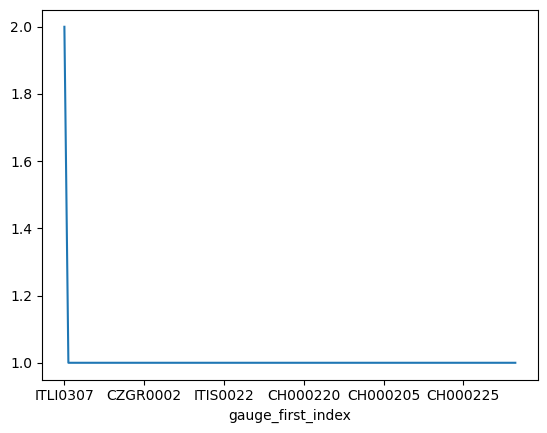

In [15]:
dist_df['gauge_first_index'].value_counts().plot()

In [ ]:
# Here we add the list of duplicated suspects:

In [73]:
network_estreams["duplicate_suspect"] = np.nan

In [74]:
for gauge in tqdm.tqdm(dist_df.gauge_first_index):
    
    duplicated_list = str(dist_df.gauge_second_index[dist_df.gauge_first_index == gauge].tolist()).replace("[", "")
    duplicated_list = duplicated_list.replace("]", "")
    duplicated_list = duplicated_list.replace("'", "")
    network_estreams.loc[gauge, "duplicated_suspect"] = duplicated_list
    network_estreams.loc[gauge, "duplicated_suspect"] = network_estreams.loc[gauge, "duplicated_suspect"]

100%|█████████████████████████████████████████| 97/97 [00:00<00:00, 2560.93it/s]


In [76]:
network_estreams

gauge_id           gauge_name gauge_country gauge_provider  \
basin_id                                                              
AT000001   200014                Bangs            AT        AT_EHYD   
AT000002   200048  Schruns (Vonbunweg)            AT        AT_EHYD   
AT000003   231662        Loruens-Aeule            AT        AT_EHYD   
AT000004   200592    Kloesterle (OEBB)            AT        AT_EHYD   
AT000005   200097  Buers (Bruecke L82)            AT        AT_EHYD   
...           ...                  ...           ...            ...   
UAGR0017  6682300          BASHTANOVKA            UA        UA_GRDC   
UAGR0018  6682500                YALTA            UA        UA_GRDC   
UAGR0019  6683010           PIONERSKOE            UA        UA_GRDC   
UAGR0020  6683200               TOKMAK            UA        UA_GRDC   
UAGR0021  6683300          NOVOSELOVKA            UA        UA_GRDC   

              river   lon_snap   lat_snap        lon        lat    area  ...  \
basin_id                                                                 ...   
AT000001      Rhein   9.534835  47.273748   9.534835  47.273748  4647.9  ...   
AT000002       Litz   9.913677  47.080301   9.913677  47.080301   102.0  ...   
AT000003        Ill   9.847765  47.132821   9.847765  47.132821   535.2  ...   
AT000004     Alfenz  10.061843  47.128994  10.061843  47.128994    66.6  ...   
AT000005     Alvier   9.802668  47.150770   9.802668  47.150770    72.2  ...   
...             ...        ...        ...        ...        ...     ...  ...   
UAGR0017      KACHA  33.894739  44.691884  33.900000  44.683333   321.0  ...   
UAGR0018  DERE-KIOY  34.166667  44.500000  34.166667  44.500000    49.7  ...   
UAGR0019     SALHYR  34.199841  44.887685  34.200000  44.883333   261.0  ...   
UAGR0020     TOKMAK  35.705833  47.251389  35.705833  47.251389   760.0  ...   
UAGR0021     KRYNKA  38.144722  48.153333  38.144722  48.153333   582.0  ...   

         area_perc  start_date   end_date  num_years num_months num_days  \
basin_id                                                                   
AT000001 -0.440608  1996-01-01 2019-12-31         24        288     8766   
AT000002 -0.281373  1958-10-01 2019-12-31         62        735    22372   
AT000003 -0.205344  1985-01-02 2019-12-31         35        420    12782   
AT000004  0.471471  1998-01-02 2019-12-31         22        264     8034   
AT000005 -0.343490  1990-01-01 2019-12-31         30        360    10957   
...            ...         ...        ...        ...        ...      ...   
UAGR0017 -1.361371  1978-01-01 1987-12-31         10        120     3652   
UAGR0018  4.237425  1978-01-01 1987-12-31         10        120     3652   
UAGR0019  6.233333  1978-01-01 1987-12-31         10        120     3652   
UAGR0020  3.806184  1978-01-01 1987-12-31         10        120     3652   
UAGR0021 -3.024055  1978-01-01 1987-12-31         10        120     3652   

          num_days_gaps  num_continuous_days  duplicate_suspect  \
basin_id                                                          
AT000001            0.0                 8766                NaN   
AT000002            0.0                22372                NaN   
AT000003            0.0                12782                NaN   
AT000004            0.0                 8034                NaN   
AT000005            0.0                10957                NaN   
...                 ...                  ...                ...   
UAGR0017            0.0                 3652                NaN   
UAGR0018            0.0                 3652                NaN   
UAGR0019            0.0                 3652                NaN   
UAGR0020            0.0                 3652                NaN   
UAGR0021            0.0                 3652                NaN   

          duplicated_suspect  
basin_id                      
AT000001                 nan  
AT000002          [CH000221]  
AT000003                 nan  
AT000004          [CH000227]

In [18]:
# Save the data:
network_estreams.to_excel("results/estreams_gauging_stations.xlsx")

## Analysis of the duplicates:

In [26]:
print("The number of duplicates suspects is", network_estreams.duplicated_suspect.count())

The number of duplicates suspects is 155


In [27]:
155/15047

0.010301056689041004

In [19]:
network_duplicates = pd.DataFrame(network_estreams.groupby('gauge_country')['duplicated_suspect'].count())
network_duplicates.head(50)

duplicated_suspect
gauge_country                    
AT                             33
BA                              0
BE                              0
BG                              0
BY                              0
CH                             35
CY                              0
CZ                             51
DE                              2
DK                              0
EE                              0
ES                              0
FI                              0
FR                              0
GB                              0
GR                              0
HR                              0
HU                             10
IE                              0
IS                              0
IT                             20
LT                              0
LU                              1
LV                              0
MD                              0
MK                              0
NI                              0
NL                              0
NO                              0
PL                              3
PT                              0
RO                              0
RS                              0
RU                              0
SE                              0
SI                              0
SK                              0
TR                              0
UA                              0

# End